## Using Deep Learning to Classify Leak Cause and Predict Failure Time Frame in Gas Pipelines: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tf.random.set_seed(123)              #will keep results same
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#Load data
df_load = pd.read_csv('mechanical_fitting_file_cleaned.csv')
df_load.head(2)

,OPERATOR_ID,REPORT_TYPE,OPERATOR_NAME,HQ_ADDRESS_CITY,HQ_ADDRESS_STATE,HQ_ADDRESS_ZIP,FAILURE_STATE,MF_INVOLVED_TEXT,MF_TYPE_TEXT,LEAK_LOCATION_A_TEXT,...,FIRST_PIPE_UNIT_TEXT,FIRST_PIPE_MATERIAL_TEXT,SECOND_PIPE_NOMINAL_SIZE_TEXT,SECOND_PIPE_UNIT_TEXT,SECOND_PIPE_MATERIAL_TEXT,LEAK_CAUSE_TEXT,LEAK_OCCURRED_TEXT,DELTA_ASOF_FILING_YEARS,DELTA_FAILURE_INSTALLED_YEARS,ADDITIONAL_LEAK_FEATURES
0,1209.0,INITIAL,COLUMBIA GAS OF MASSACHUSETTS,WESTBOROUGH,MA,01581,MA,NUT FOLLOWER,VALVE,BELOWGROUND,...,IPS,STEEL,0.75,IPS,STEEL,OTHER,LEAKED THROUGH SEAL,0.095890,36.0,UNKNOWN
1,1209.0,INITIAL,COLUMBIA GAS OF MASSACHUSETTS,WESTBOROUGH,MA,01581,MA,NUT FOLLOWER,RISER,BELOWGROUND,...,IPS,STEEL,0.50,CTS,POLYETHYLENE (PE),CORROSION,LEAKED THROUGH BODY,0.117808,54.0,UNKNOWN


In [3]:
#Split data into features and labels
cat_cols= df_load.select_dtypes(['object'])
num_cols = df_load.select_dtypes(['int', 'float']).set_index(['OPERATOR_ID', 'YEAR_INSTALLED'])
cat_features = cat_cols.drop('LEAK_CAUSE_TEXT', axis = 1)
label = df_load['LEAK_CAUSE_TEXT'].unique()
cat_label =  pd.DataFrame(label, columns = ['category_label'])

In [4]:
#Transfrom categorical data in to numerical values: One-Hot
le = LabelEncoder()
encoded_feature_lables=cat_features.astype(str).apply(le.fit_transform)
cat_features_one_hot = pd.get_dummies(data=encoded_feature_lables, columns=encoded_feature_lables.columns, drop_first=True)

df_load['LEAK_CAUSE_LABELS'] = cat_cols.astype(str).apply(le.fit_transform)["LEAK_CAUSE_TEXT"]
model_labels = df_load.groupby('LEAK_CAUSE_TEXT')['LEAK_CAUSE_LABELS'].unique()
model_labels

LEAK_CAUSE_TEXT
AGE                                  [0]
BACKFILL                             [1]
BELL JOINT                           [2]
BURRIED IN SNOW                      [3]
COMPRESSION COUPLING                 [4]
CONSTRUCTION/INSTALLATION DEFECT     [5]
CORROSION                            [6]
DESIGN DEFECT                        [7]
ELASTOMER FAILURE                    [8]
EQUIPMENT                            [9]
EXCAVATION DAMAGE                   [10]
EXCESSIVE EARTH LOAD                [11]
GASKET                              [12]
GASKET O-RING                       [13]
GREASE                              [14]
GROUND MOVEMENT                     [15]
INCORRECT OPERATION                 [16]
LOOSE BOLTS                         [17]
LOOSE FITTING                       [18]
MATERIAL DEFECT                     [19]
MATERIAL OR WELDS/FUSIONS           [20]
NATURAL FORCES                      [21]
NOT PROVIDED BY REPAIR CREW         [22]
NUT FOLLOWER                        [23]


In [5]:
df_load.columns

Index(['OPERATOR_ID', 'REPORT_TYPE', 'OPERATOR_NAME', 'HQ_ADDRESS_CITY',
       'HQ_ADDRESS_STATE', 'HQ_ADDRESS_ZIP', 'FAILURE_STATE',
       'MF_INVOLVED_TEXT', 'MF_TYPE_TEXT', 'LEAK_LOCATION_A_TEXT',
       'LEAK_LOCATION_B_TEXT', 'LEAK_LOCATION_C_TEXT', 'YEAR_INSTALLED',
       'MANUFACTURE', 'MANUFACTURE_MAPPED', 'MODEL_NUMBER', 'LOT_ATTRIBUTES',
       'FITTING_MATERIAL_TEXT', 'FIRST_PIPE_NOMINAL_SIZE_TEXT',
       'FIRST_PIPE_UNIT_TEXT', 'FIRST_PIPE_MATERIAL_TEXT',
       'SECOND_PIPE_NOMINAL_SIZE_TEXT', 'SECOND_PIPE_UNIT_TEXT',
       'SECOND_PIPE_MATERIAL_TEXT', 'LEAK_CAUSE_TEXT', 'LEAK_OCCURRED_TEXT',
       'DELTA_ASOF_FILING_YEARS', 'DELTA_FAILURE_INSTALLED_YEARS',
       'ADDITIONAL_LEAK_FEATURES', 'LEAK_CAUSE_LABELS'],
      dtype='object')

#### Matrix One Hot

In [6]:
model_data_one_hot =pd.concat([df_load, cat_features_one_hot], axis =1).drop(cat_cols, axis =1)
model_data_one_hot.head()

predictors_on_hot  = model_data_one_hot.drop(['OPERATOR_ID', 'YEAR_INSTALLED', 'LEAK_CAUSE_LABELS'], axis = 1)
target_one_hot = to_categorical(model_data_one_hot['LEAK_CAUSE_LABELS'])

predictors_on_hot = np.asarray(predictors_on_hot)
target_one_hot = np.asarray(target_one_hot)

In [7]:
predictors_on_hot, target_one_hot

(array([[0.75      , 0.75      , 0.09589041, ..., 0.        , 1.        ,
         0.        ],
        [0.75      , 0.5       , 0.11780822, ..., 0.        , 1.        ,
         0.        ],
        [0.75      , 0.75      , 0.1260274 , ..., 0.        , 1.        ,
         0.        ],
        ...,
        [0.75      , 1.25      , 7.25479452, ..., 0.        , 0.        ,
         1.        ],
        [2.        , 2.        , 7.1260274 , ..., 0.        , 1.        ,
         0.        ],
        [2.        , 2.        , 7.1890411 , ..., 0.        , 1.        ,
         0.        ]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [8]:
#Split
X_train, X_test, y_train, y_test = train_test_split(predictors_on_hot,target_one_hot, test_size = 0.2, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((68488, 3910), (17123, 3910), (68488, 38), (17123, 38))

In [9]:
model_oh = tf.keras.Sequential()

In [10]:
#Adding Layers
model_oh.add(tf.keras.layers.BatchNormalization(input_shape = (3910,)))
model_oh.add(tf.keras.layers.Dense(1614, activation= 'relu', input_shape = (3910,)))
model_oh.add(tf.keras.layers.Dropout(0.2))
model_oh.add(tf.keras.layers.Dense(1200, activation= 'relu'))
model_oh.add(tf.keras.layers.Dropout(0.3))
model_oh.add(tf.keras.layers.Dense(38,  activation= 'softmax'))

In [11]:
model_oh.compile(optimizer='adam', loss='categorical_crossentropy', metrics=  ['accuracy'])

In [12]:
#call_back_1=EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [13]:
#Fit Model: 

#model_oh.fit(X_train, y_train,
             #validation_data=(X_test, y_test),
             #batch_size=5,
             #epochs=5,
             #verbose=2)

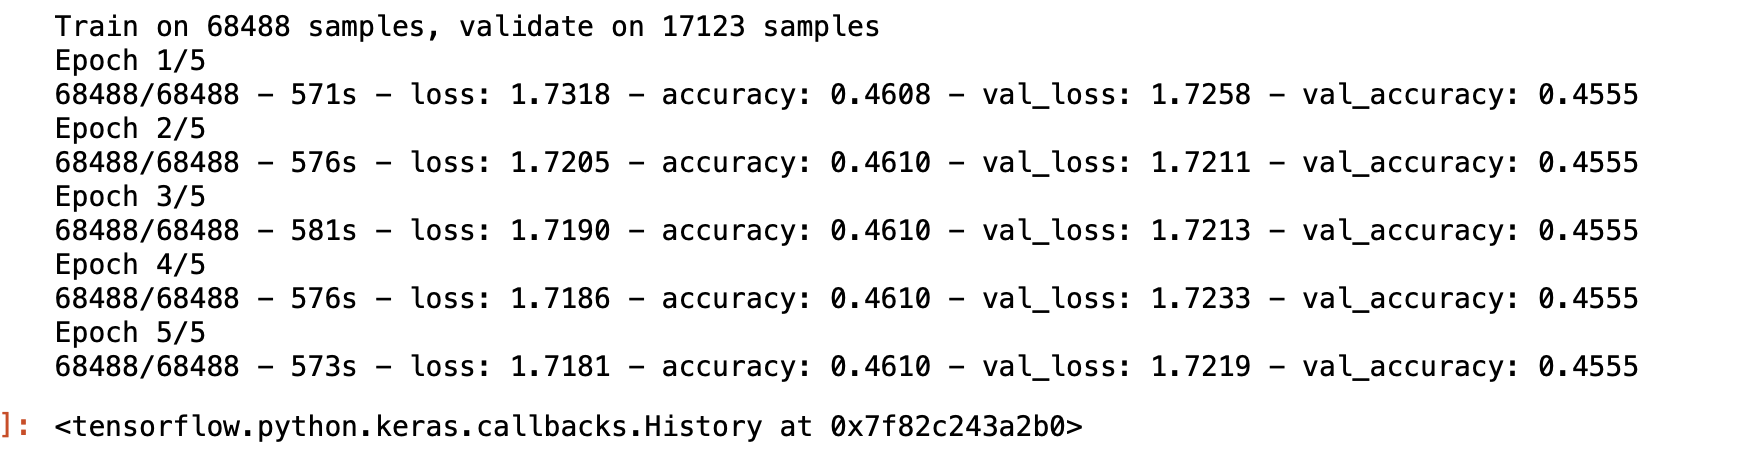

#### Observation:
1. Due to large number of predictor columns (3910), neural net model did not work well.
2. Will use Binary encoder and re-run the model. 
3. Number nodes is the average of features and labels.

#### Matrix Binary Encoded:

In [14]:
#Transfrom categorical data in to numerical values: Binary encoder:
be = BinaryEncoder()

cat_features_be=be.fit_transform(cat_features)
cat_features_be.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85611 entries, 0 to 85610
Columns: 136 entries, REPORT_TYPE_0 to ADDITIONAL_LEAK_FEATURES_3
dtypes: int64(136)
memory usage: 88.8 MB


In [15]:
#Concat categorical features with df_load:
model_data_be = pd.concat([df_load,cat_features_be], axis =1).drop(cat_cols, axis =1)

#Drop columns: 
predictors_be = model_data_be.drop(['OPERATOR_ID','YEAR_INSTALLED', 'LEAK_CAUSE_LABELS'], axis =1)

#Prepare Lables for Leak Cause:
target_be = model_data_be['LEAK_CAUSE_LABELS'].astype(int)

In [16]:
predictors_be.head()

,FIRST_PIPE_NOMINAL_SIZE_TEXT,SECOND_PIPE_NOMINAL_SIZE_TEXT,DELTA_ASOF_FILING_YEARS,DELTA_FAILURE_INSTALLED_YEARS,REPORT_TYPE_0,REPORT_TYPE_1,OPERATOR_NAME_0,OPERATOR_NAME_1,OPERATOR_NAME_2,OPERATOR_NAME_3,...,SECOND_PIPE_MATERIAL_TEXT_3,SECOND_PIPE_MATERIAL_TEXT_4,SECOND_PIPE_MATERIAL_TEXT_5,LEAK_OCCURRED_TEXT_0,LEAK_OCCURRED_TEXT_1,LEAK_OCCURRED_TEXT_2,ADDITIONAL_LEAK_FEATURES_0,ADDITIONAL_LEAK_FEATURES_1,ADDITIONAL_LEAK_FEATURES_2,ADDITIONAL_LEAK_FEATURES_3
0,0.75,0.75,0.095890,36.0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,0.75,0.50,0.117808,54.0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,0.75,0.75,0.126027,43.0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,2.00,2.00,0.128767,53.0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,1.00,1.00,0.128767,33.0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [17]:
#Transform labels: 
target_labels_be = to_categorical(target_be)
target_labels_be.shape
target_labels_be

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
#Normalize Predictors: 
sc_be = StandardScaler()
predictors_sc_be = sc_be.fit_transform(predictors_be)

In [19]:
predictors_sc_be.shape, target_labels_be.shape

X_be = np.asarray(predictors_sc_be)
y_be = np.asarray(target_labels_be)

In [20]:
#Split Train test: 
X_train_be, X_test_be, y_train_be, y_test_be = train_test_split(X_be,y_be, test_size = 0.2, random_state = 123)
X_train_be.shape, X_test_be.shape, y_train_be.shape, y_test_be.shape


((68488, 140), (17123, 140), (68488, 38), (17123, 38))

In [21]:
X_test_be.dtype

dtype('float64')

In [22]:
#Initiate Model:
model_be = tf.keras.Sequential()

In [23]:
#Add Input, hidden, dropout Layers:
model_be.add(tf.keras.layers.Dense(160,  activation= 'relu', input_shape = (140,)))
model_be.add(tf.keras.layers.Dropout(0.03))
model_be.add(tf.keras.layers.Dense(158, activation= 'relu'))
model_be.add(tf.keras.layers.Dropout(0.02))
model_be.add(tf.keras.layers.Dense(38, activation= 'softmax'))

In [24]:
#Compile Nueral Net:
model_be.compile(optimizer='adam', loss='categorical_crossentropy', metrics=  ['accuracy'])

In [25]:
call_back=EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [26]:
#Fit Model:
model_be.fit(X_train_be, y_train_be , validation_data= (X_test_be, y_test_be), batch_size=100, epochs=30, callbacks=[call_back])

Train on 68488 samples, validate on 17123 samples
Epoch 1/30
68488/68488 [==============================] - 2s 29us/sample - loss: 0.5184 - accuracy: 0.8526 - val_loss: 0.3502 - val_accuracy: 0.8866
Epoch 2/30
68488/68488 [==============================] - 1s 21us/sample - loss: 0.3310 - accuracy: 0.8925 - val_loss: 0.3209 - val_accuracy: 0.8969
Epoch 3/30
68488/68488 [==============================] - 1s 21us/sample - loss: 0.3017 - accuracy: 0.9014 - val_loss: 0.3088 - val_accuracy: 0.8973
Epoch 4/30
68488/68488 [==============================] - 2s 23us/sample - loss: 0.2839 - accuracy: 0.9048 - val_loss: 0.2990 - val_accuracy: 0.9014
Epoch 5/30
68488/68488 [==============================] - 2s 24us/sample - loss: 0.2728 - accuracy: 0.9081 - val_loss: 0.2977 - val_accuracy: 0.9008
Epoch 6/30
68488/68488 [==============================] - 2s 24us/sample - loss: 0.2605 - accuracy: 0.9109 - val_loss: 0.2982 - val_accuracy: 0.9018


#### Prepare table to capture predicted labels: 

In [27]:
#Predictors: 
predictors=pd.DataFrame(X_test_be, columns = predictors_be.columns)

In [28]:
#Transform labels to integer lables: 
df_model_labels = pd.DataFrame(model_labels).reset_index()
df_model_labels['LEAK_CAUSE_LABELS'] = range(0,38)
df_model_labels.head()
df_model_labels.columns= ['predicted_leak_cause_text', 'LEAK_CAUSE_LABELS']

In [29]:
#Predict Leak Cause: 
y_pred_be =  model_be.predict(X_test_be)
predicted_labels = np.argmax(y_pred_be, axis = 1)
predicted_labels = pd.DataFrame(predicted_labels,columns= ['predicted_labels'])

#Concat predicted labels with Predictors:
result =  pd.concat([predictors,predicted_labels],axis = 1)

In [30]:
#Merge Predicted labels with Leak Cause Text: 
result_Leak_cause=pd.merge(left = result, right = df_model_labels, left_on= 'predicted_labels', right_on= 'LEAK_CAUSE_LABELS', how = 'inner').drop('LEAK_CAUSE_LABELS', axis =1)

predicted_leak_cause_text  predicted_labels
EQUIPMENT                  9                   8102
NATURAL FORCES             21                  2663
MATERIAL OR WELDS/FUSIONS  20                  2529
INCORRECT OPERATION        16                  1742
CORROSION                  6                    795
Name: predicted_labels, dtype: int64


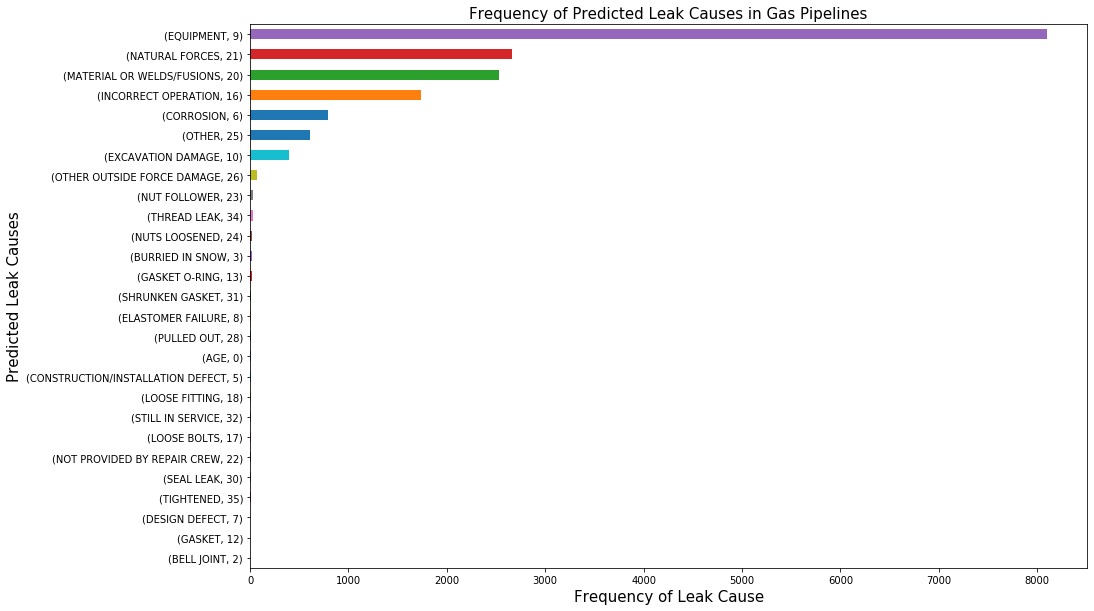

In [31]:
#Print Result: 
print(result_Leak_cause.iloc[:, -2:].groupby('predicted_leak_cause_text')['predicted_labels'].value_counts().sort_values(ascending = False).head())
result_Leak_cause.iloc[:, -2:].groupby('predicted_leak_cause_text')['predicted_labels'].value_counts().sort_values(ascending = True).plot.barh(figsize = (15,10))
_ = plt.xlabel('Frequency of Leak Cause', fontsize = 15)
_ = plt.ylabel('Predicted Leak Causes', fontsize = 15)
_ = plt.title('Frequency of Predicted Leak Causes in Gas Pipelines', fontsize = 15)

#### Observation:
1. Neural net resulted in validation accuracy of 90.18%.
2. Equipment remains to be the main reason behind leak cause. 

In [32]:
#Binary Encoded Model Summary
model_be.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 160)               22560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 158)               25438     
_________________________________________________________________
dropout_3 (Dropout)          (None, 158)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 38)                6042      
Total params: 54,040
Trainable params: 54,040
Non-trainable params: 0
_________________________________________________________________


#### Predicting Failure Date:

In [33]:
#Concat categorical features with df_load:
#model_data_be = pd.concat([df_load,cat_features_be], axis =1).drop(cat_cols, axis =1)

#Drop columns: 
predictors_be_date = model_data_be.drop(['OPERATOR_ID','YEAR_INSTALLED', 'DELTA_FAILURE_INSTALLED_YEARS'], axis =1)

#Prepare Lables for Leak Cause:
target_be_date = model_data_be['DELTA_FAILURE_INSTALLED_YEARS'].astype(int)

In [34]:
#Predict Features: 
fail_predictors= np.asarray(predictors_be_date)

#Target Failure Date:
fail_date_label= np.array(target_be_date)

In [35]:
fail_predictors

array([[0.75      , 0.75      , 0.09589041, ..., 0.        , 0.        ,
        1.        ],
       [0.75      , 0.5       , 0.11780822, ..., 0.        , 0.        ,
        1.        ],
       [0.75      , 0.75      , 0.1260274 , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.75      , 1.25      , 7.25479452, ..., 0.        , 1.        ,
        1.        ],
       [2.        , 2.        , 7.1260274 , ..., 0.        , 0.        ,
        1.        ],
       [2.        , 2.        , 7.1890411 , ..., 0.        , 0.        ,
        1.        ]])

In [36]:
#Split Train Test: 
X_train_fail, X_test_fail, y_train_fail, y_test_fail = train_test_split(fail_predictors,fail_date_label, test_size = 0.20, random_state = 123)

In [37]:
#Shape
X_train_fail.shape, X_test_fail.shape, y_train_fail.shape, y_test_fail.shape

((68488, 140), (17123, 140), (68488,), (17123,))

In [38]:
#Initiate Model: 
model_date = tf.keras.Sequential()

In [39]:
#Add Layers: 
#Add Input, hidden, dropout Layers:
model_date.add(tf.keras.layers.Dense(160,  activation= 'relu', input_shape = (140,)))
model_date.add(tf.keras.layers.Dropout(0.03))
model_date.add(tf.keras.layers.Dense(158, activation= 'relu'))
model_date.add(tf.keras.layers.Dropout(0.02))
model_date.add(tf.keras.layers.Dense(1, activation= 'relu'))

In [40]:
#Compile Neural Net:
model_date.compile(optimizer='adam', loss= 'mean_squared_logarithmic_error')

In [41]:
#Fit model: 
model_date.fit(X_train_fail, y_train_fail,
               validation_data=(X_test_fail,y_test_fail),
               batch_size=50,
               epochs= 25,
               verbose=2)

Train on 68488 samples, validate on 17123 samples
Epoch 1/25
68488/68488 - 3s - loss: 0.3525 - val_loss: 0.3000
Epoch 2/25
68488/68488 - 2s - loss: 0.2717 - val_loss: 0.2782
Epoch 3/25
68488/68488 - 2s - loss: 0.2597 - val_loss: 0.2773
Epoch 4/25
68488/68488 - 2s - loss: 0.2518 - val_loss: 0.2779
Epoch 5/25
68488/68488 - 2s - loss: 0.2459 - val_loss: 0.2695
Epoch 6/25
68488/68488 - 2s - loss: 0.2419 - val_loss: 0.2686
Epoch 7/25
68488/68488 - 2s - loss: 0.2369 - val_loss: 0.2750
Epoch 8/25
68488/68488 - 2s - loss: 0.2343 - val_loss: 0.2681
Epoch 9/25
68488/68488 - 2s - loss: 0.2308 - val_loss: 0.2581
Epoch 10/25
68488/68488 - 2s - loss: 0.2277 - val_loss: 0.2617
Epoch 11/25
68488/68488 - 2s - loss: 0.2252 - val_loss: 0.2603
Epoch 12/25
68488/68488 - 2s - loss: 0.2220 - val_loss: 0.2595
Epoch 13/25
68488/68488 - 2s - loss: 0.2209 - val_loss: 0.2652
Epoch 14/25
68488/68488 - 2s - loss: 0.2176 - val_loss: 0.2597
Epoch 15/25
68488/68488 - 2s - loss: 0.2147 - val_loss: 0.2608
Epoch 16/25
68

In [42]:
#Fit trained model to test data 
y_pred_fail = model_date.predict(X_test_fail)

In [43]:
#Transform result into dataframe
df_fail_predcitors_test = pd.DataFrame(X_test_fail, columns = predictors_be_date.columns)

In [44]:
df_failure_timeframe = pd.DataFrame(y_pred_fail, columns = ['predicted_failure_years'])
df_failure_timeframe.head()

,predicted_failure_years
0,36.076229
1,25.836668
2,56.066231
3,16.676826
4,43.833714


#### Build table containing predicted labels and failure time frame:

In [45]:
result_Leak_cause['predicted_failure_years'] = df_failure_timeframe
result_Leak_cause.iloc[:, -2:].groupby('predicted_leak_cause_text')['predicted_failure_years'].value_counts().sort_values(ascending = False).head()

predicted_leak_cause_text  predicted_failure_years
EQUIPMENT                  0.000000                   15
                           52.512680                   7
                           52.883549                   5
                           53.245766                   4
                           52.853153                   4
Name: predicted_failure_years, dtype: int64

In [46]:
#Merge 
result_combined = pd.merge(df_load, result_Leak_cause[['predicted_leak_cause_text', 'predicted_labels','predicted_failure_years']], how = 'left',left_index = True, right_index = True)

In [47]:
#Select non-missing values:
result_combined = result_combined[result_combined['predicted_failure_years'].notnull()]

In [48]:
#Show Table: 
result_combined[['OPERATOR_ID', 'OPERATOR_NAME','HQ_ADDRESS_CITY', 'MANUFACTURE','LEAK_CAUSE_TEXT', 'DELTA_FAILURE_INSTALLED_YEARS', 'predicted_labels','predicted_leak_cause_text', 'predicted_failure_years']].drop('LEAK_CAUSE_TEXT', axis =1).head(2)

,OPERATOR_ID,OPERATOR_NAME,HQ_ADDRESS_CITY,MANUFACTURE,DELTA_FAILURE_INSTALLED_YEARS,predicted_labels,predicted_leak_cause_text,predicted_failure_years
0,1209.0,COLUMBIA GAS OF MASSACHUSETTS,WESTBOROUGH,"DRESSER (DRESSER MANUFACTURING, DRESSER PIPING...",36.0,9.0,EQUIPMENT,36.076229
1,1209.0,COLUMBIA GAS OF MASSACHUSETTS,WESTBOROUGH,UNKNOWN,54.0,9.0,EQUIPMENT,25.836668


#### Summary of Same Year Leak Cause:

Same Year Leak Casue:
                            count  percent
EQUIPMENT                     15    51.72
INCORRECT OPERATION            4    13.79
CORROSION                      3    10.34
NATURAL FORCES                 3    10.34
OTHER                          2     6.90
MATERIAL OR WELDS/FUSIONS      2     6.90


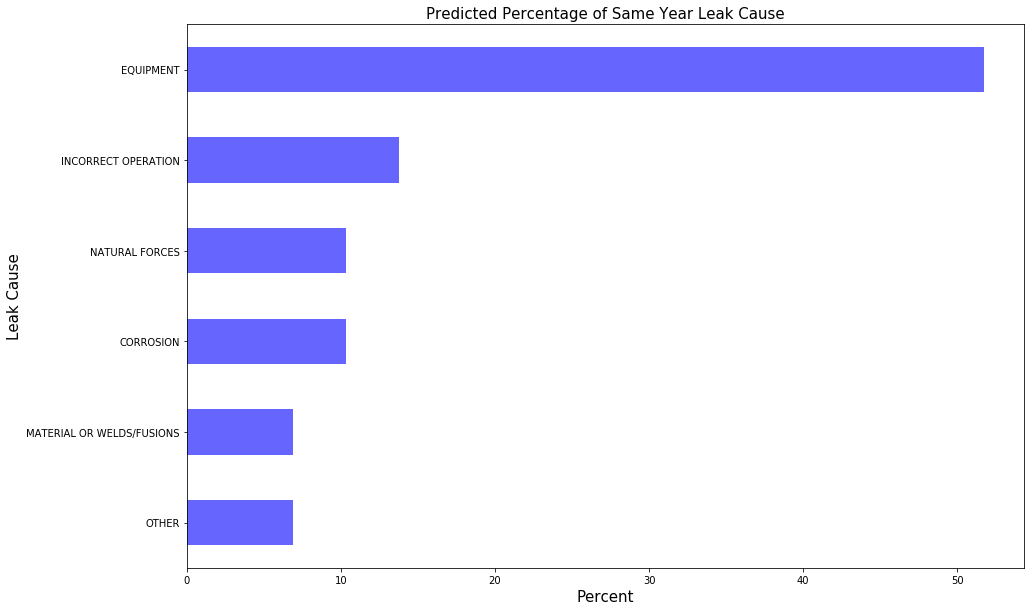

In [49]:
same_year_count = result_combined['predicted_leak_cause_text'][result_combined['predicted_failure_years']==0]
count = same_year_count.value_counts()
percent = round((count/count.sum()*100),2)
df_same_year_count = pd.concat([count, percent], axis = 1)
df_same_year_count.columns = ['count', 'percent']
print('Same Year Leak Casue:\n', df_same_year_count)
df_same_year_count['percent'].sort_values(ascending = True).plot.barh(figsize = (15,10), color= 'blue', alpha = 0.6)
_ = plt.xlabel('Percent', fontsize = 15)
_ = plt.ylabel('Leak Cause', fontsize = 15)
_ = plt.title('Predicted Percentage of Same Year Leak Cause', fontsize = 15)

#### Frequency of Predicted Leak Causes by Manufacturers:

Predicted Frequency of Leak Cause by Manufacturers: 
 
 MANUFACTURE                                                  predicted_leak_cause_text
UNKNOWN                                                      EQUIPMENT                    3543
DRESSER (DRESSER MANUFACTURING, DRESSER PIPING SPECIALTIES)  EQUIPMENT                    1791
UNKNOWN                                                      MATERIAL OR WELDS/FUSIONS    1490
                                                             INCORRECT OPERATION          1231
                                                             NATURAL FORCES               1117
Name: predicted_leak_cause_text, dtype: int64


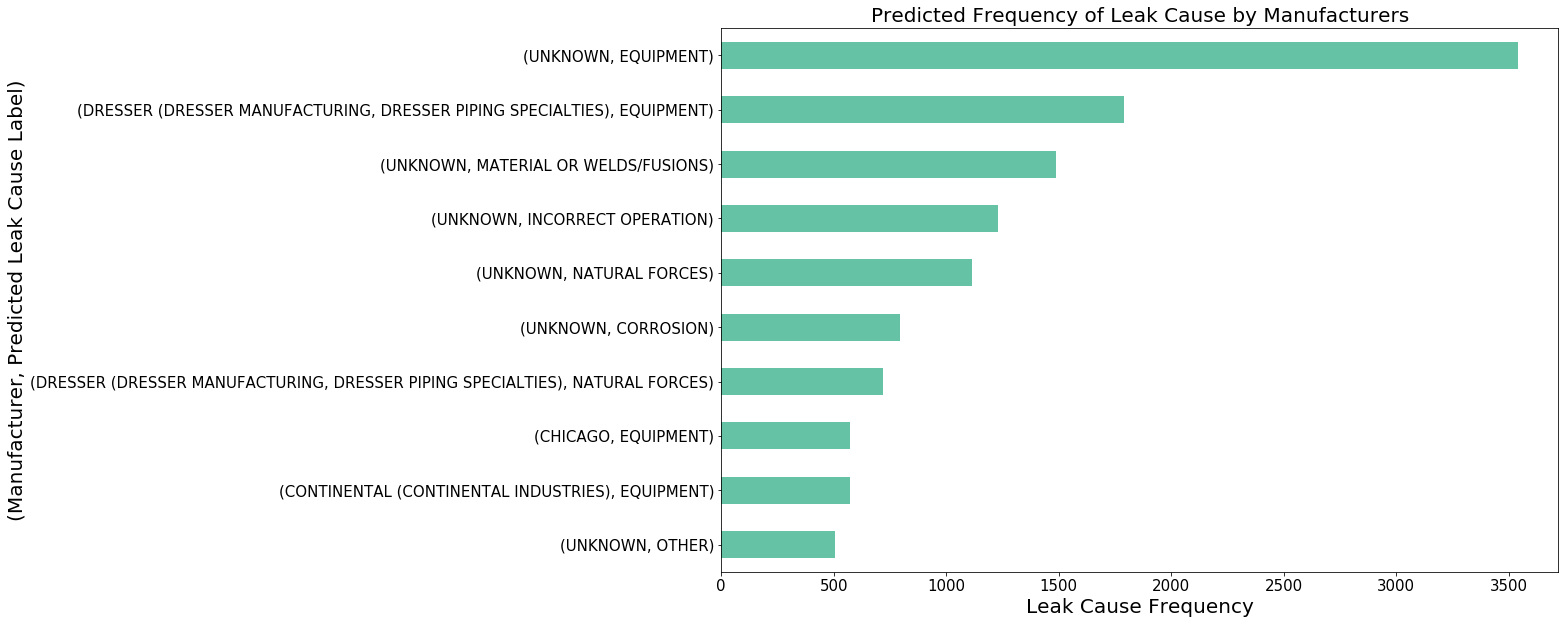

In [86]:

print('Predicted Frequency of Leak Cause by Manufacturers: \n \n',result_combined.groupby('MANUFACTURE')['predicted_leak_cause_text'].value_counts().sort_values(ascending = False).head())
result_combined.groupby('MANUFACTURE')['predicted_leak_cause_text'].value_counts().sort_values(ascending = True).tail(10).plot.barh(figsize= (15,10),
                                                                                                                                    fontsize = 15,
                                                                                                                                    cmap = 'Set2')
_ = plt.xlabel('Leak Cause Frequency', fontsize = 20)
_ = plt.ylabel("(Manufacturer, Predicted Leak Cause Label)", fontsize = 20)
_ = plt.title('Predicted Frequency of Leak Cause by Manufacturers', fontsize = 20)

#### Observation: 
1. Majority of equipment failures are unknown. 
2. Dresser accounted for maximum equipment failures compared to other services they offer. 

Table showing predicted Time Frame of Leak Cause:
 
                            minimum_life  maximum_life
predicted_leak_cause_text                            
BURRIED IN SNOW               11.713003     88.369522
EQUIPMENT                      0.000000     86.631874
NATURAL FORCES                 0.000000     83.479279
AGE                            5.653286     80.604584
INCORRECT OPERATION            3.153261     75.921120
Maximum Average Life of Mechanical Fittings: 61.8
Minimum Average Life of Mechanical Fitting: 15.18
Average Predicted Life of Fittings 41.75


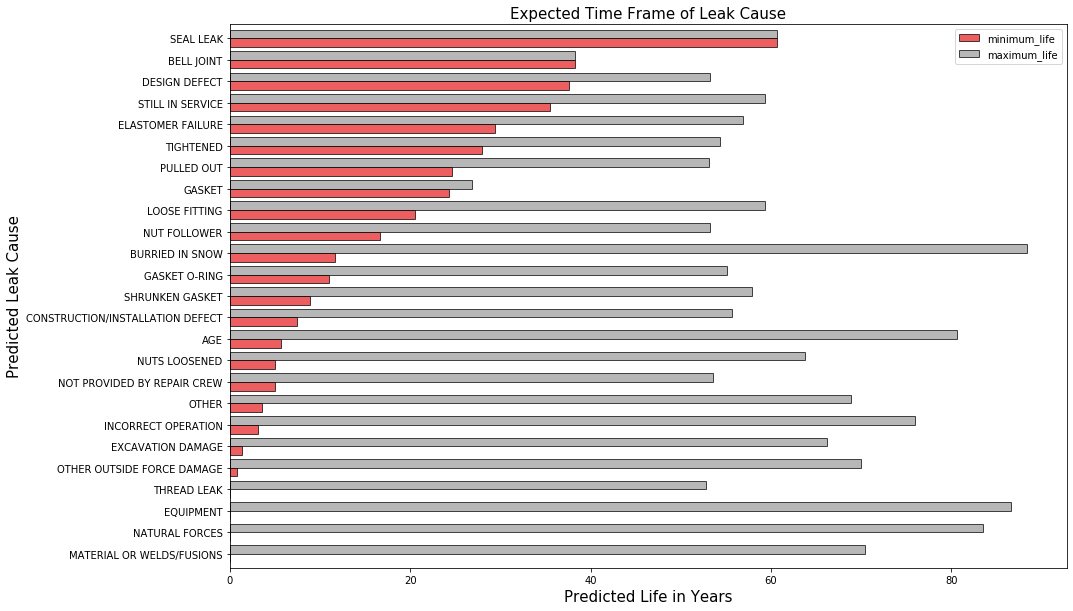

In [101]:
#Minimum and Maximum Life of Predicted Leak Cause:  
max_min_range = result_combined[result_combined['MANUFACTURE']!='UNKNOWN'].groupby(['predicted_leak_cause_text'])['predicted_failure_years'].agg({'minimum_life': 'min', 'maximum_life': 'max'})
print('Table showing predicted Time Frame of Leak Cause:\n \n', max_min_range.sort_values('maximum_life', ascending = False).head())
max_min_range.sort_values('minimum_life', ascending = True).plot.barh(figsize = (15,10), cmap = 'Set1', fontsize = 10, width = 0.8, edgecolor = 'black', alpha = 0.7, stacked = False)
_ = plt.xlabel('Predicted Life in Years', fontsize = 15)
_ = plt.ylabel('Predicted Leak Cause', fontsize = 15)
_ = plt.title('Expected Time Frame of Leak Cause', fontsize = 15)
print('Maximum Average Life of Mechanical Fittings:', round(max_min_range['maximum_life'].mean(),2))
print('Minimum Average Life of Mechanical Fitting:',round(max_min_range['minimum_life'].mean(),2))
print('Average Predicted Life of Fittings', round(result_combined['predicted_failure_years'].mean(),2))

Maximum Life Variation:
 
 predicted_leak_cause_text
EQUIPMENT          86.631874
NATURAL FORCES     83.479279
BURRIED IN SNOW    76.656517
AGE                74.951294
Name: life_variance, dtype: float32 
 
Minimum Life Variation:
 
 predicted_leak_cause_text
SEAL LEAK     0.0
BELL JOINT    0.0
Name: life_variance, dtype: float32


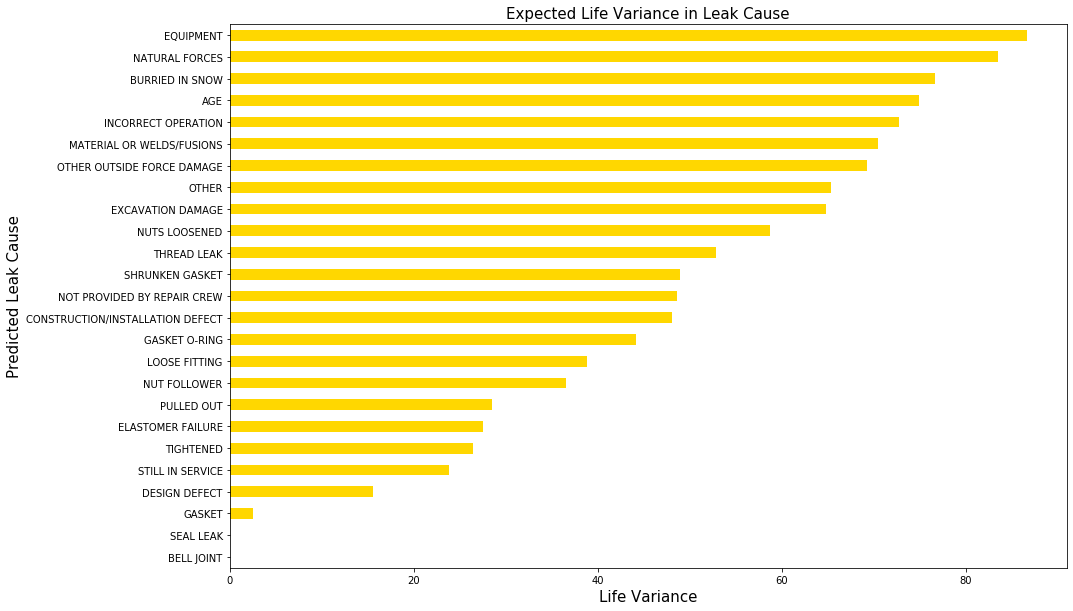

In [102]:
max_min_range['life_variance'] = max_min_range['maximum_life'] - max_min_range['minimum_life']
print('Maximum Life Variation:\n \n', max_min_range['life_variance'].sort_values(ascending= False).head(4), '\n \n' 'Minimum Life Variation:\n \n', max_min_range['life_variance'].sort_values(ascending= False).tail(2))
max_min_range['life_variance'].sort_values(ascending= True).plot.barh(figsize = (15,10), color = 'gold')
_ = plt.xlabel('Life Variance', fontsize = 15)
_ = plt.ylabel('Predicted Leak Cause', fontsize = 15)
_ = plt.title('Expected Life Variance in Leak Cause', fontsize = 15)

#### Observation: 
1. Leaks caused due to equipment, natural forces and burried in snow could have maximum life variations. 
2. Leaks caused due to seal leak and bell joint have zero life variations.  

In [103]:
max_min_range = round(max_min_range[['minimum_life', 'maximum_life', 'life_variance']].astype(float),2)
max_min_range.head()

,minimum_life,maximum_life,life_variance
predicted_leak_cause_text,,,
AGE,5.65,80.60,74.95
BELL JOINT,38.28,38.28,0.00
BURRIED IN SNOW,11.71,88.37,76.66
CONSTRUCTION/INSTALLATION DEFECT,7.51,55.63,48.12
DESIGN DEFECT,37.63,53.24,15.61


In [104]:
print('Zero Life Variation Defects:\n', max_min_range[max_min_range['life_variance']==0])
print('Average Life of Zero Variation Defects:', round((max_min_range['maximum_life'][max_min_range['life_variance']==0]).mean(),2))

Zero Life Variation Defects:
                            minimum_life  maximum_life  life_variance
predicted_leak_cause_text                                           
BELL JOINT                        38.28         38.28            0.0
SEAL LEAK                         60.72         60.72            0.0
Average Life of Zero Variation Defects: 49.5


#### Observation: 
1. Thread Leak, Equipment, natural forces and welding could fail as early as within the same year while some lasting an average of 61.80 years. 
2. Seal leak and bell joint with zero life variation can last an average life of 49.50 years. 
3. We need to study the reason for high life variance and why fittings failed before the minimum average life of 15.18 years?  

#### Age of mechanical fittings:

In [105]:
#Cleaning values in lot attributes:
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNVAVAILABLE'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNKNOWN'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'NONE'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNK'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == '1-1/4"""'], '1.25')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == '"2"""'], '2')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == '"3/4"""'], '0.75')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == '"1/2"""'], '0.5')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UKN'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNLNOWN'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == '"1-1/4"""'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNKNWON'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'YNAVAILABLE'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'POSILOCK'], 'POSI-LOCK')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'NOT APPLICABLE '], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == '"1 1/8"""'], '1.125')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == '"3"""'], '3')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == ' '], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNAVAILBLE'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNAVAILAABLE'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'NOT APPLICABLE'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNAVAILAVBE'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNAVALIABLE'], 'UNAVAILABLE')
result_combined['LOT_ATTRIBUTES'] = result_combined['LOT_ATTRIBUTES'].replace(result_combined['LOT_ATTRIBUTES'][result_combined['LOT_ATTRIBUTES'] == 'UNAVAIABLE'], 'UNAVAILABLE')

In [150]:
# Identify age range of various fittings:
mfg_max_min_supply = result_combined[(result_combined['MANUFACTURE']!='UNKNOWN') & (result_combined['LOT_ATTRIBUTES']!='UNAVAILABLE')].groupby(['MANUFACTURE','predicted_leak_cause_text', 'LOT_ATTRIBUTES' ])['predicted_failure_years'].agg({'minimum_life': 'min', 'maximum_life':'max', 'supply_count': 'count'})

In [161]:
#Sort fittings by minimum life
mfg_max_min_supply.sort_values('minimum_life',ascending= True).head()

minimum_life  \
MANUFACTURE                                        predicted_leak_cause_text LOT_ATTRIBUTES                                 
PERFECTION                                         EQUIPMENT                 PERMASERT                           2.322948   
OTHER                                              MATERIAL OR WELDS/FUSIONS CONNECTION - STAB                   3.412651   
                                                                             CONNECTION - OTHER COMPRESSION      4.319154   
CONTINENTAL (CONTINENTAL INDUSTRIES)               NATURAL FORCES            CRACKED OUTLET                      4.968024   
DRESSER (DRESSER MANUFACTURING, DRESSER PIPING ... MATERIAL OR WELDS/FUSIONS CONNECTION NUT FOLLOWER             6.412117   

                                                                                                             maximum_life  \
MANUFACTURE                                        predicted_leak_cause_text LOT_ATTRIBUTES                                 
PERFECTION                                         EQUIPMENT                 PERMASERT                          63.355377   
OTHER                                              MATERIAL OR WELDS/FUSIONS CONNECTION - STAB                  53.448997   
                                                                             CONNECTION - OTHER COMPRESSION     58.520718   
CONTINENTAL (CONTINENTAL INDUSTRIES)               NATURAL FORCES            CRACKED OUTLET                      4.968024   
DRESSER (DRESSER MANUFACTURING, DRESSER PIPING ... MATERIAL OR WELDS/FUSIONS CONNECTION NUT FOLLOWER            53.592041   

                                                                                                             supply_count  
MANUFACTURE                                        predicted_leak_cause_text LOT_ATTRIBUTES                                
PERFECTION                                         EQUIPMENT                 PERMASERT                                 26  
OTHER                                              MATERIAL OR WELDS/FUSIONS CONNECTION - STAB                          5  
                                                                             CONNECTION - OTHER COMPRESSION             9  
CONTINENTAL (CONTINENTAL INDUSTRIES)               NATURAL FORCES            CRACKED OUTLET                             1  
DRESSER (DRESSER MANUFACTURING, DRESSER PIPING ... MATERIAL OR WELDS/FUSIONS CONNECTION NUT FOLLOWER                    6

minimum_life  \
MANUFACTURE                                        predicted_leak_cause_text LOT_ATTRIBUTES                                 
DRESSER (DRESSER MANUFACTURING, DRESSER PIPING ... MATERIAL OR WELDS/FUSIONS CONNECTION NUT FOLLOWER             6.412117   
INNER-TITE                                         EQUIPMENT                 POSI-LOCK                           8.305901   
MUELLER                                            NATURAL FORCES            2                                  12.569158   
OTHER                                              MATERIAL OR WELDS/FUSIONS CONNECTION - OTHER COMPRESSION      4.319154   
                                                                             CONNECTION - STAB                   3.412651   
PERFECTION                                         EQUIPMENT                 PERMASERT                           2.322948   

                                                                                                             maximum_life  \
MANUFACTURE                                        predicted_leak_cause_text LOT_ATTRIBUTES                                 
DRESSER (DRESSER MANUFACTURING, DRESSER PIPING ... MATERIAL OR WELDS/FUSIONS CONNECTION NUT FOLLOWER            53.592041   
INNER-TITE                                         EQUIPMENT                 POSI-LOCK                          55.978275   
MUELLER                                            NATURAL FORCES            2                                  52.918533   
OTHER                                              MATERIAL OR WELDS/FUSIONS CONNECTION - OTHER COMPRESSION     58.520718   
                                                                             CONNECTION - STAB                  53.448997   
PERFECTION                                         EQUIPMENT                 PERMASERT                          63.355377   

                                                                                                             supply_count  
MANUFACTURE                                        predicted_leak_cause_text LOT_ATTRIBUTES                                
DRESSER (DRESSER MANUFACTURING, DRESSER PIPING ... MATERIAL OR WELDS/FUSIONS CONNECTION NUT FOLLOWER                    6  
INNER-TITE                                         EQUIPMENT                 POSI-LOCK                                 30  
MUELLER                                            NATURAL FORCES            2                                          5  
OTHER                                              MATERIAL OR WELDS/FUSIONS CONNECTION - OTHER COMPRESSION             9  
                                                                             CONNECTION - STAB                          5  
PERFECTION                                         EQUIPMENT                 PERMASERT                                 26

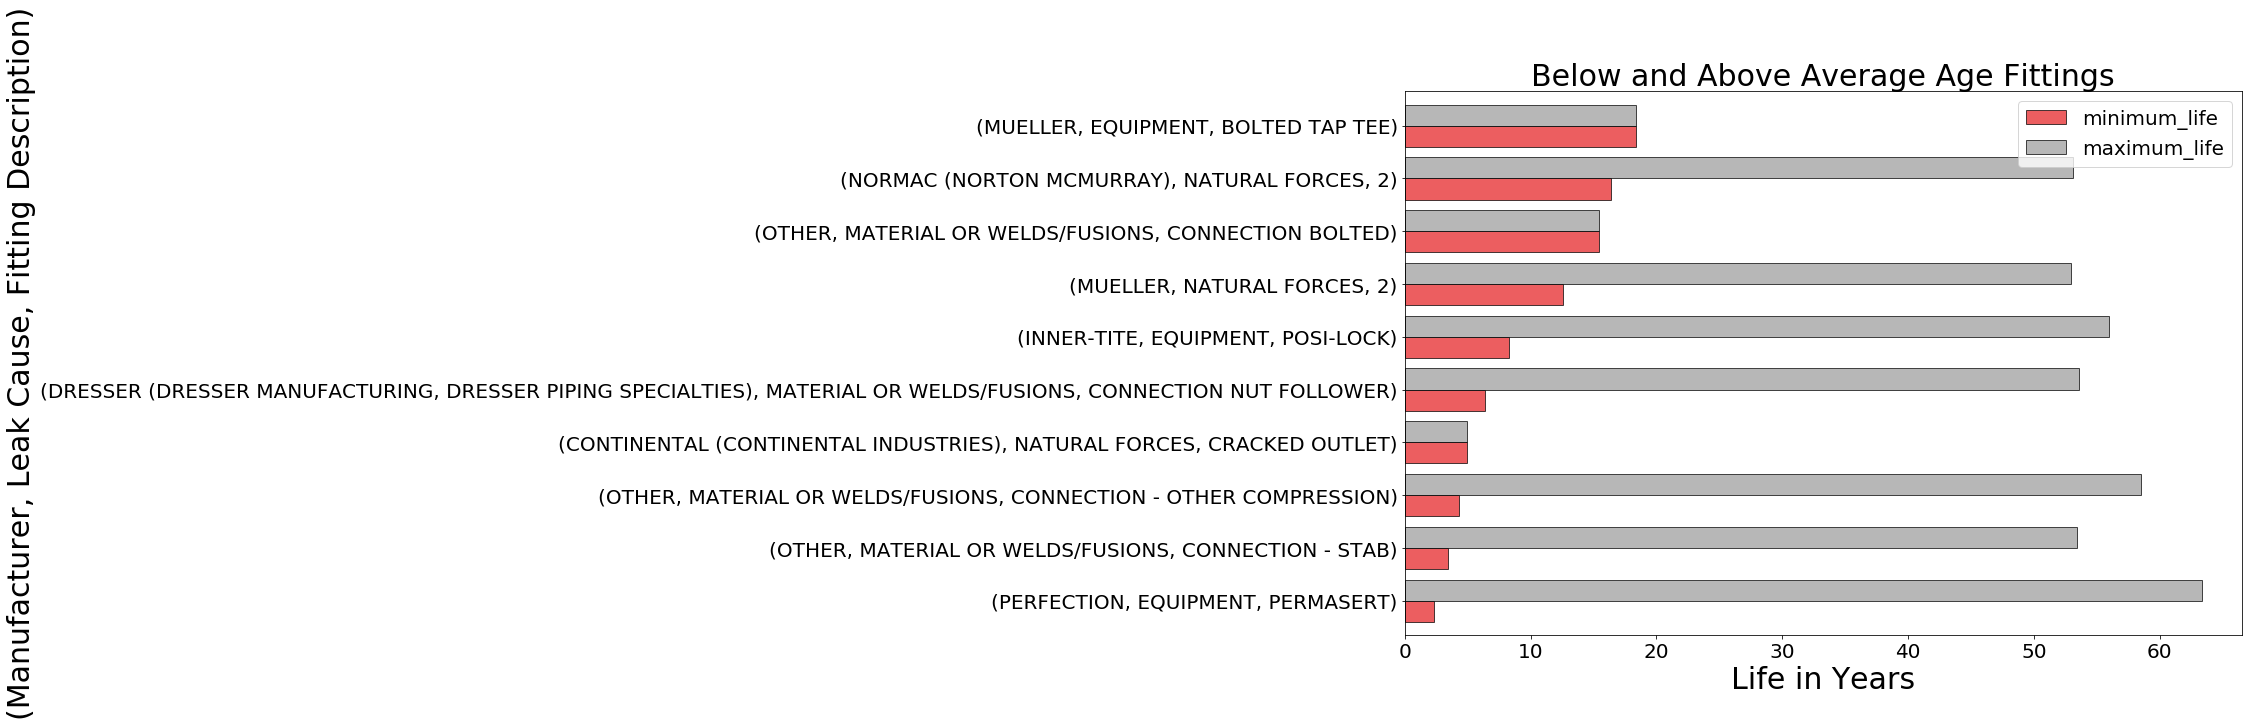

In [186]:
#Plot Below and Above Average Age Fittings:
mfg_max_min_supply[['minimum_life', 'maximum_life']].sort_values('minimum_life',ascending= True).head(10).plot.barh(figsize = (15,10), cmap = 'Set1', fontsize = 20, width = 0.8, edgecolor = 'black', alpha = 0.7, stacked = False)
_ = plt.legend(fontsize = 20)
_ = plt.ylabel('(Manufacturer, Leak Cause, Fitting Description)', fontsize =30)
_ = plt.xlabel('Life in Years', fontsize = 30)
_ = plt.title('Below and Above Average Age Fittings', fontsize = 30)

#Filter Below and Above Average Age Fittings: 
min_life_fittings = pd.DataFrame(mfg_max_min_supply)
min_life_fittings[(min_life_fittings['minimum_life']<=15.18) & (min_life_fittings['maximum_life']>=41.75)]

In [59]:
#Reset Index:
mfg_max_min_supply = mfg_max_min_supply.reset_index()

#### Percentage of Leaks Every 10 Years: 

In [60]:
counts = [] #empty list
decades = [10,20,30,40,50,60,70,80] # range from 10 to 80 years
for one_decade in decades:
    minimum_count = mfg_max_min_supply[mfg_max_min_supply['minimum_life']<=one_decade].groupby('LOT_ATTRIBUTES')['minimum_life'].value_counts().agg({'total':'sum'})
    counts.append(minimum_count)
df_minimum_count=pd.DataFrame(counts)

In [61]:
df_minimum_count.head()

,total
minimum_life,6
minimum_life,14
minimum_life,29
minimum_life,40
minimum_life,60


In [62]:
df_minimum_count['at_life_yrs'] = decades

In [63]:
df_minimum_count = df_minimum_count.reset_index().drop('index', axis =1)
df_minimum_count = df_minimum_count.set_index('at_life_yrs')

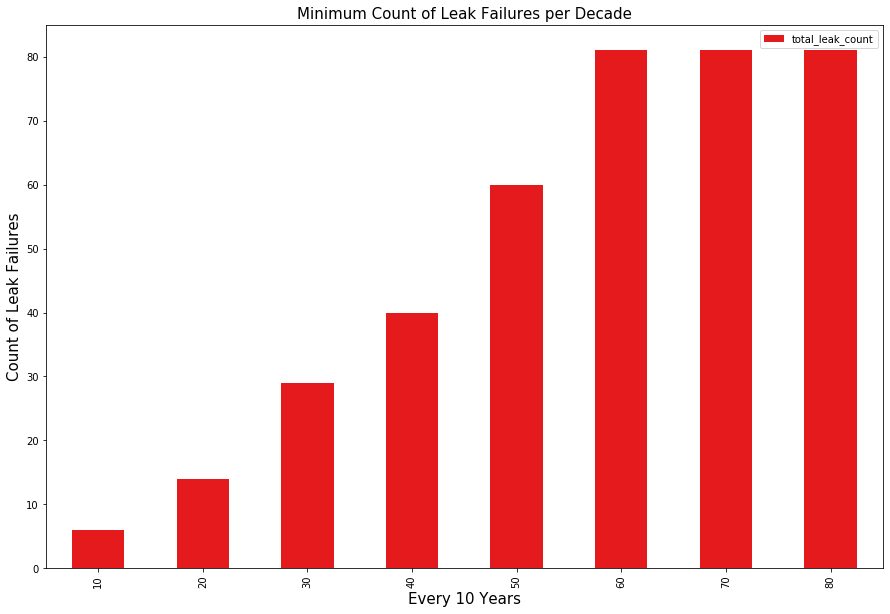

In [64]:
df_minimum_count.columns = ['total_leak_count']
df_minimum_count.plot.bar(figsize = (15,10), cmap = 'Set1')
_ = plt.xlabel('Every 10 Years', fontsize = 15)
_ = plt.ylabel('Count of Leak Failures', fontsize = 15)
_ = plt.title('Minimum Count of Leak Failures per Decade', fontsize = 15)

In [65]:
#Percentage of Leak per decade:
df_minimum_count["percent_leak_decade"] = ((df_minimum_count['total_leak_count']/ df_minimum_count['total_leak_count'].sum()) * 100).round(2)

             total_leak_count  percent_leak_decade
at_life_yrs                                       
10                          6                 1.53
20                         14                 3.57
30                         29                 7.40
40                         40                10.20
50                         60                15.31
60                         81                20.66
70                         81                20.66
80                         81                20.66


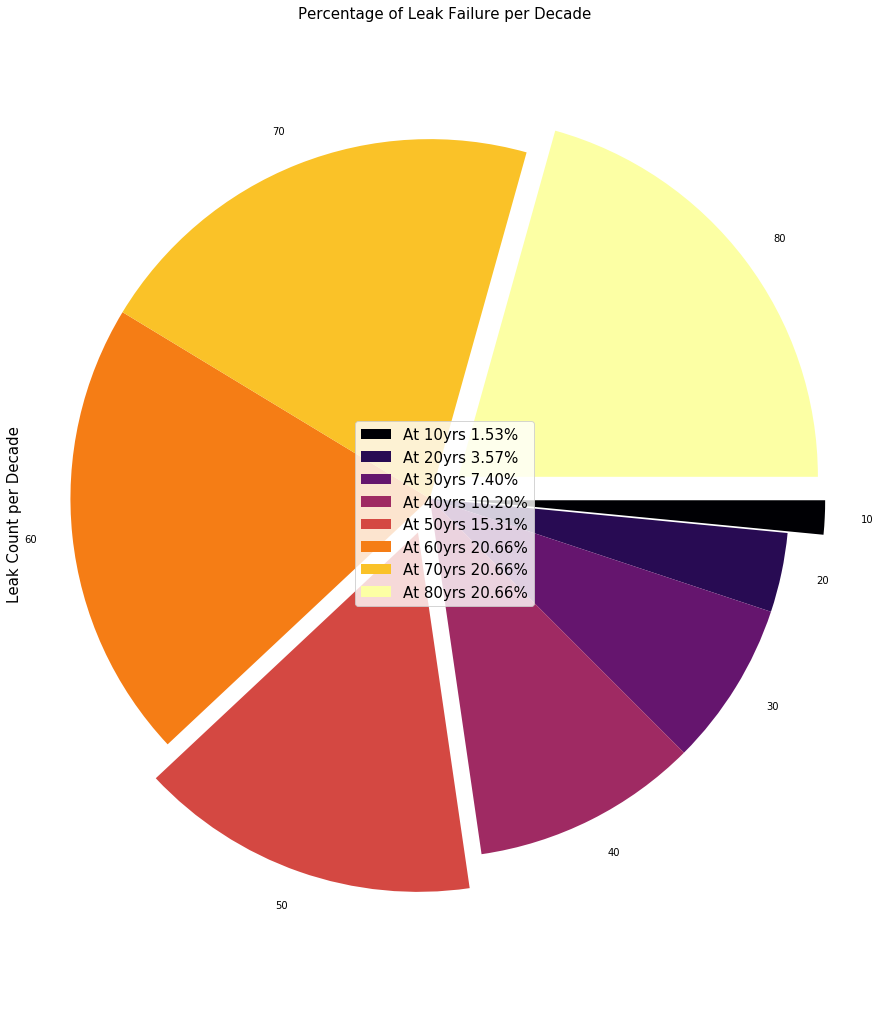

In [83]:
#Plot of Percentage of Leak Per Decade:
_ = plt.figure(figsize = (15,18))
print(df_minimum_count)
df_minimum_count["percent_leak_decade"].plot('pie', counterclock=False, explode = [0.1,0,0,0,.1,0,0,.1], cmap = 'inferno')
_ = plt.legend(['At 10yrs 1.53%', 'At 20yrs 3.57%', 'At 30yrs 7.40%', 'At 40yrs 10.20%', 'At 50yrs 15.31%', 'At 60yrs 20.66%', 'At 70yrs 20.66%', 'At 80yrs 20.66%'], loc='center', fontsize = 15)
_ = plt.axis('equal')
_ = plt.ylabel('Leak Count per Decade',  fontsize = 15)
_ = plt.title('Percentage of Leak Failure per Decade', fontsize = 15)

#### Observation: 
1. At 10 years 1.53% and at 80 years 20.66% pipelines could leak due to mechanical fitting failures.

In [67]:
import pgeocode as pg #import package 

In [68]:
#Initiate US library
usa = pg.Nominatim('us')
usa

In [69]:
#Get Latitude and Longitude
df_location = usa.query_postal_code(list(result_combined['HQ_ADDRESS_ZIP']))#[['place_name', 'state_name', 'latitude','longitude']]
df_location['state_name'].unique()#.head()

array(['Massachusetts', 'Tennessee', 'Indiana', 'Alaska', 'Alabama',
       'Florida', nan, 'North Carolina', 'Georgia', 'New Jersey',
       'Michigan', 'Missouri', 'Nebraska', 'District of Columbia', 'Ohio',
       'Texas', 'Arizona', 'Illinois', 'Maryland', 'New York', 'Colorado',
       'Kentucky', 'Pennsylvania', 'Virginia', 'Connecticut',
       'Mississippi', 'Delaware', 'Minnesota', 'South Carolina',
       'New Mexico', 'Louisiana', 'West Virginia', 'Idaho', 'Iowa',
       'California', 'North Dakota', 'Wisconsin', 'New Hampshire',
       'Oregon', 'Oklahoma', 'Kansas', 'Nevada', 'Vermont', 'Washington',
       'Maine'], dtype=object)

In [70]:
#Concatenate location coordinates with test data: 
df_map = pd.concat([result_combined,df_location], axis =1).drop(['place_name', 'state_name'], axis =1)
df_map.head(2)

,OPERATOR_ID,REPORT_TYPE,OPERATOR_NAME,HQ_ADDRESS_CITY,HQ_ADDRESS_STATE,HQ_ADDRESS_ZIP,FAILURE_STATE,MF_INVOLVED_TEXT,MF_TYPE_TEXT,LEAK_LOCATION_A_TEXT,...,postal_code,country code,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,1209.0,INITIAL,COLUMBIA GAS OF MASSACHUSETTS,WESTBOROUGH,MA,01581,MA,NUT FOLLOWER,VALVE,BELOWGROUND,...,01581,US,MA,Worcester,27.0,NaN,NaN,42.2679,-71.6176,4.0
1,1209.0,INITIAL,COLUMBIA GAS OF MASSACHUSETTS,WESTBOROUGH,MA,01581,MA,NUT FOLLOWER,RISER,BELOWGROUND,...,01581,US,MA,Worcester,27.0,NaN,NaN,42.2679,-71.6176,4.0


#### Plot map coordinates: 

In [71]:
import geopandas as gp #import package

In [72]:
#Get geometry coordinates in Geodataframe:
us_map=gp.GeoDataFrame(df_location, geometry=gp.points_from_xy(df_location.longitude, df_location.latitude))
us_map.head(2)

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy,geometry
0,01581,US,Westborough,Massachusetts,MA,Worcester,27.0,NaN,NaN,42.2679,-71.6176,4.0,POINT (-71.6176 42.2679)
1,01581,US,Westborough,Massachusetts,MA,Worcester,27.0,NaN,NaN,42.2679,-71.6176,4.0,POINT (-71.6176 42.2679)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
139,1379302771,Asia,China,CHN,21140000.0,(POLYGON ((109.4752095886636 18.19770091396857...
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."
98,1281935911,Asia,India,IND,8721000.0,"POLYGON ((97.32711388549004 28.26158274994634,..."


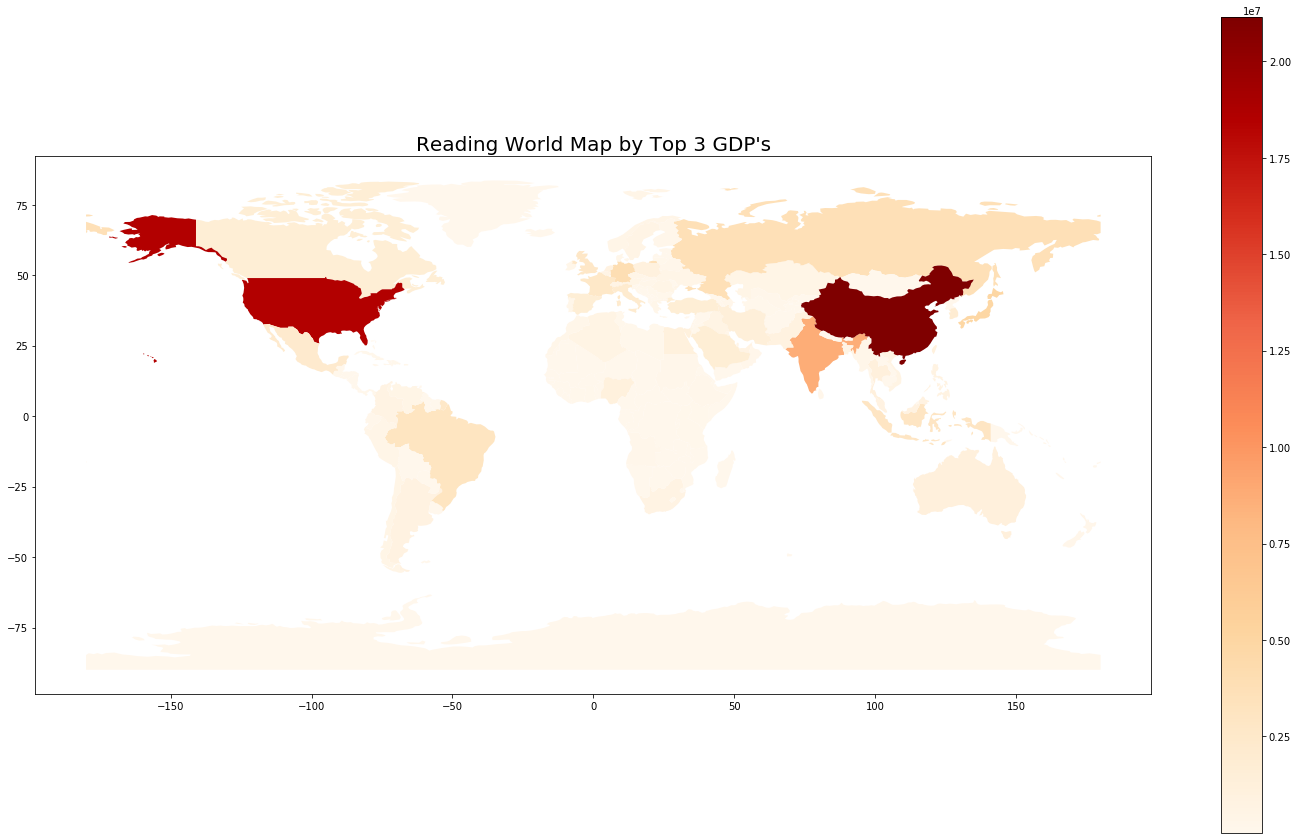

In [73]:
#Read world map:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
world.plot(column = 'gdp_md_est', figsize = (25,15), cmap = 'OrRd', legend = True)
_ = plt.title("Reading World Map by Top 3 GDP's", fontsize = 20)
world.sort_values('gdp_md_est', ascending = False).head(3)

#### Observation:
1. China, US and India ar ethe top 3 GDP's. 
2. We only have gas pipeline data for the US.

Map Summary:
 postal_code       174
country code        1
place_name        162
state_name         44
state_code         44
county_name       146
county_code        84
community_name      0
community_code      0
latitude          169
longitude         169
accuracy            2
geometry          170
dtype: int64


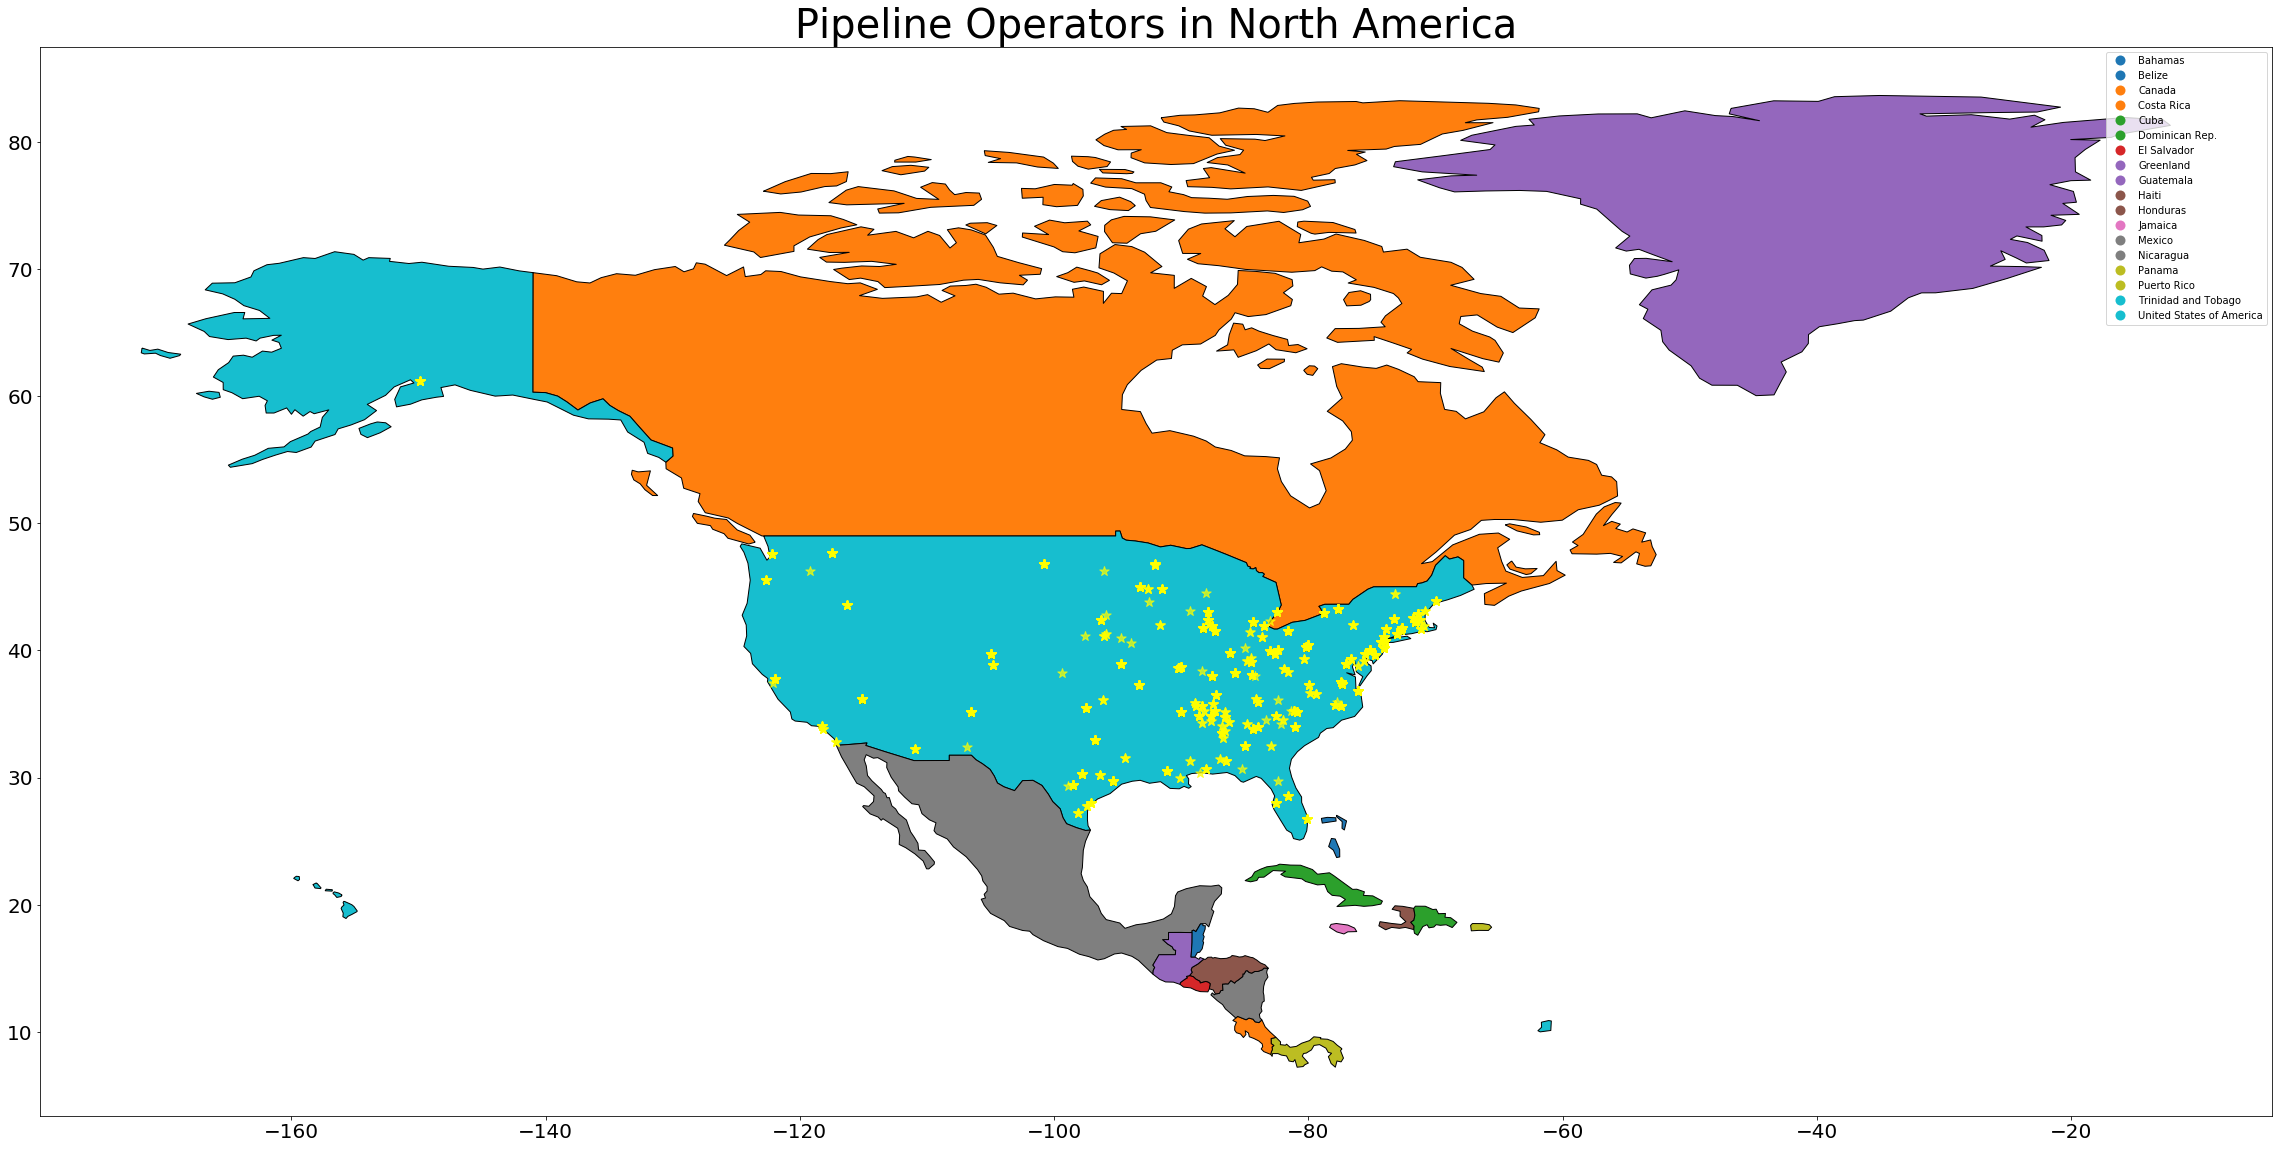

In [194]:
#Plottting Coordinates of Pipeline Operators in North America: 
ax = world[world.continent == 'North America'].plot(column = 'name', edgecolor='black', figsize = (40,40), legend= True)
us_map.plot(ax = ax, color = 'yellow', alpha = 0.7, marker = '*', markersize = 100)
_ = plt.title('Pipeline Operators in North America', fontsize = 40)
_ = plt.xticks(fontsize = 20)
_ = plt.yticks(fontsize = 20)
print('Map Summary:\n',us_map.nunique())

In [75]:
#Leak Cause by State:
df_summary_count = df_map.groupby(['HQ_ADDRESS_STATE'])['predicted_leak_cause_text'].agg({'count': 'value_counts'}).reset_index()

#### Count of various leak causes per state:

                  predicted_leak_cause_text  count
HQ_ADDRESS_STATE                                  
IL                                EQUIPMENT   1253
IN                                EQUIPMENT   1123
DC                      INCORRECT OPERATION   1098
TX                                EQUIPMENT   1014
PA                MATERIAL OR WELDS/FUSIONS    899


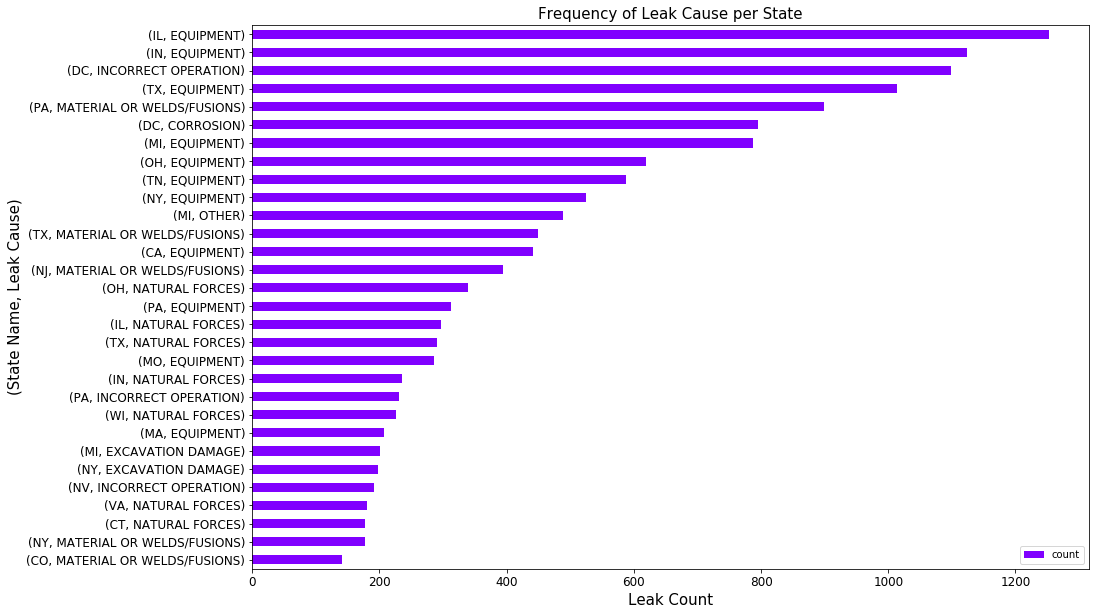

In [76]:
print(df_summary_count.set_index(['HQ_ADDRESS_STATE']).sort_values('count', ascending = False).head())
df_summary_count.set_index(['HQ_ADDRESS_STATE','predicted_leak_cause_text']).sort_values('count' , ascending =True).tail(30).plot.barh(figsize = (15,10), cmap = 'rainbow', fontsize = 12)
_ = plt.xlabel('Leak Count', fontsize = 15)
_ = plt.ylabel('(State Name, Leak Cause)', fontsize = 15)
_ = plt.title('Frequency of Leak Cause per State', fontsize = 15)

#### Summary table of leaks per state across US: 

In [92]:
#Pivot Table:
df_summary_count_pivot = pd.pivot_table(data = df_summary_count, index = 'HQ_ADDRESS_STATE',columns= 'predicted_leak_cause_text',  values='count',aggfunc= 'sum', margins = True, margins_name= 'TOTAL_LEAKS_STATE').reset_index()

#Percent leak per state:
df_summary_count_pivot['PERCENT_LEAK_STATE'] = df_summary_count_pivot['TOTAL_LEAKS_STATE'][:-1]/df_summary_count_pivot['TOTAL_LEAKS_STATE'][:-1].sum() * 100

#Sort values by percent leak:
df_plotly = df_summary_count_pivot[['HQ_ADDRESS_STATE','TOTAL_LEAKS_STATE','PERCENT_LEAK_STATE']].iloc[:-1].sort_values('PERCENT_LEAK_STATE', ascending = False)

#Round percent leak to 2 decimal points:
df_plotly['PERCENT_LEAK_STATE'] = df_plotly['PERCENT_LEAK_STATE'].round(2)

#Merge summary table (df_plotly) with test data table(result_combined):
df_plotly_merge_0 = pd.merge(left = df_plotly, right = result_combined[['OPERATOR_NAME','HQ_ADDRESS_STATE', 'MANUFACTURE', 'predicted_leak_cause_text','predicted_failure_years']], on = 'HQ_ADDRESS_STATE', how = 'inner').drop_duplicates()

#Round predicted failure years in to integer: 
df_plotly_merge_0['predicted_failure_years'] = df_plotly_merge_0['predicted_failure_years'].astype(int)

df_plotly_merge_0.head()

,HQ_ADDRESS_STATE,TOTAL_LEAKS_STATE,PERCENT_LEAK_STATE,OPERATOR_NAME,MANUFACTURE,predicted_leak_cause_text,predicted_failure_years
0,DC,1941,11.34,WASHINGTON GAS LIGHT CO,UNKNOWN,EQUIPMENT,56
1,DC,1941,11.34,WASHINGTON GAS LIGHT CO,UNKNOWN,INCORRECT OPERATION,42
2,DC,1941,11.34,WASHINGTON GAS LIGHT CO,UNKNOWN,INCORRECT OPERATION,47
3,DC,1941,11.34,WASHINGTON GAS LIGHT CO,UNKNOWN,INCORRECT OPERATION,52
4,DC,1941,11.34,WASHINGTON GAS LIGHT CO,UNKNOWN,INCORRECT OPERATION,10


#### Expand summary table to include more variables:

In [93]:
#Operator Count per state: 
df_ops_count = pd.DataFrame(df_plotly_merge_0.groupby('HQ_ADDRESS_STATE')['OPERATOR_NAME'].nunique())

#Manufacturer count per state: 
df_mfg_count = pd.DataFrame(df_plotly_merge_0.groupby('HQ_ADDRESS_STATE')['MANUFACTURE'].nunique())

#Types of leak cause per state: 
df_type_count = pd.DataFrame(df_plotly_merge_0.groupby('HQ_ADDRESS_STATE')['predicted_leak_cause_text'].nunique())

#Minimum Leaks per state:
df_life_min = pd.DataFrame(df_plotly_merge_0.groupby('HQ_ADDRESS_STATE')['predicted_failure_years'].min())


#Maximum Leaks per state:
df_life_max = pd.DataFrame(df_plotly_merge_0.groupby('HQ_ADDRESS_STATE')['predicted_failure_years'].max())


#Average Leaks per state:
df_life_avg = pd.DataFrame(df_plotly_merge_0.groupby('HQ_ADDRESS_STATE')['predicted_failure_years'].mean())

#Change Column Names: 
df_ops_count.columns, df_mfg_count.columns, df_type_count.columns, df_life_min.columns, df_life_max.columns, df_life_avg.columns = ['OPERATOR_COUNT_STATE'], ['MANUFACTURER_COUNT_STATE'], ['LEAK_TYPE_COUNT_STATE'], ['MINIMUM_LIFE_STATE'], ['MAXIMUM_LIFE_STATE'], ['AVERAGE_LIFE_STATE']

#Reset Index: 
df_ops_count, df_mfg_count, df_type_count, df_life_min, df_life_max, df_life_avg = df_ops_count.reset_index(), df_mfg_count.reset_index(), df_type_count.reset_index(), df_life_min.reset_index(), df_life_max.reset_index(), df_life_avg.reset_index()

#Merge new summary features with summary table (df_plotly): 
df_plotly_merge_1 = pd.merge(left = df_plotly, right = df_ops_count, on = 'HQ_ADDRESS_STATE', how = 'inner')
df_plotly_merge_2 = pd.merge(left = df_plotly_merge_1, right = df_mfg_count, on = 'HQ_ADDRESS_STATE', how = 'inner')
df_plotly_merge_3 = pd.merge(left = df_plotly_merge_2, right = df_type_count, on = 'HQ_ADDRESS_STATE', how = 'inner')
df_plotly_merge_4 = pd.merge(left = df_plotly_merge_3, right = df_life_min, on = 'HQ_ADDRESS_STATE', how = 'inner')
df_plotly_merge_5 = pd.merge(left = df_plotly_merge_4, right = df_life_max, on = 'HQ_ADDRESS_STATE', how = 'inner')
df_plotly_final   = pd.merge(left = df_plotly_merge_5, right = df_life_avg, on = 'HQ_ADDRESS_STATE', how = 'inner')

In [94]:
#Check Data Type: 
df_plotly_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 0 to 44
Data columns (total 9 columns):
HQ_ADDRESS_STATE            45 non-null object
TOTAL_LEAKS_STATE           45 non-null int64
PERCENT_LEAK_STATE          45 non-null float64
OPERATOR_COUNT_STATE        45 non-null int64
MANUFACTURER_COUNT_STATE    45 non-null int64
LEAK_TYPE_COUNT_STATE       45 non-null int64
MINIMUM_LIFE_STATE          45 non-null int64
MAXIMUM_LIFE_STATE          45 non-null int64
AVERAGE_LIFE_STATE          45 non-null float64
dtypes: float64(2), int64(6), object(1)
memory usage: 3.5+ KB


In [95]:
#Convert Data types: 
df_plotly_final['HQ_ADDRESS_STATE'] = df_plotly_final['HQ_ADDRESS_STATE'].astype('category')
df_plotly_final['AVERAGE_LIFE_STATE'] = df_plotly_final['AVERAGE_LIFE_STATE'].astype(int)

In [97]:
df_plotly_final.sort_values('MINIMUM_LIFE_STATE', ascending= False).head()

,HQ_ADDRESS_STATE,TOTAL_LEAKS_STATE,PERCENT_LEAK_STATE,OPERATOR_COUNT_STATE,MANUFACTURER_COUNT_STATE,LEAK_TYPE_COUNT_STATE,MINIMUM_LIFE_STATE,MAXIMUM_LIFE_STATE,AVERAGE_LIFE_STATE
44,VT,2,0.01,1,1,1,51,52,51
41,ME,12,0.07,1,2,1,25,55,46
42,AZ,8,0.05,1,3,2,24,53,45
43,NE,7,0.04,3,4,2,23,53,43
38,OR,13,0.08,1,5,1,16,55,39


In [196]:
import plotly.graph_objects as go
import pandas as pd

for col in df_plotly_final.columns:
    df_plotly_final[col] = df_plotly_final[col].astype(str)

df_plotly_final['text'] = 'State Name: ' + df_plotly_final['HQ_ADDRESS_STATE'] + '<br>' + \
'Operator Count: ' + df_plotly_final['OPERATOR_COUNT_STATE'] + '<br>' + \
'Manufacture Count: ' + df_plotly_final['MANUFACTURER_COUNT_STATE'] + '<br>' + \
'Leak Count: ' + df_plotly_final['TOTAL_LEAKS_STATE'] + '<br>' + \
'Leak Types: ' + df_plotly_final['LEAK_TYPE_COUNT_STATE'] + '<br>' + \
'Age Range: ' + df_plotly_final['MINIMUM_LIFE_STATE'] + "-" + df_plotly_final['MAXIMUM_LIFE_STATE'] + ' Years' + '<br>' + \
'Average Life: ' + df_plotly_final['AVERAGE_LIFE_STATE'] + " " +'Years'

fig = go.Figure(data=go.Choropleth(
    locations=df_plotly_final['HQ_ADDRESS_STATE'], # Spatial coordinates
    z = df_plotly_final['PERCENT_LEAK_STATE'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Percent Leaks Per State",
    autocolorscale=True,
    text=df_plotly_final['text'],
    marker_line_color='white', 
  ))

fig.update_layout(
    title_text = 'Summary of Leaks by US State',
    geo_scope='usa'
)

fig.show()


#### Observation: 
1. Texas and Washington DC represents maximum leak regions at 11.3% and 11.34%.
2. Vermont represents lowest leaks across US at 0.01% and minimum life of 51 years. 